In [1]:
import sys
!{sys.executable} -m pip install --upgrade --user pip # update the pip package installer
!{sys.executable} -m pip install -U numpy pandas uproot3 matplotlib --user # install required packages

     |████████████████████████████████| 1.7 MB 5.8 MB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
     |████████████████████████████████| 16.8 MB 36 kB/s  eta 0:00:01
     |████████████████████████████████| 11.5 MB 590 kB/s eta 0:00:01
     |████████████████████████████████| 117 kB 721 kB/s eta 0:00:01
     |████████████████████████████████| 11.2 MB 701 kB/s eta 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.5.0 requires keras-nightly~=2.5.0.dev, which is not installed.
tensorboard 2.5.0 requires tensorboard-data-server<0.7.0,>=0.6.0, which is not installed.
qkeras 0.8.0 requires tensorflow-model-optimization>=0.2.1, which is not installed.


In [2]:
import pandas as pd # to store data as dataframes
import numpy as np # for numerical calculations such as histogramming
import math # for mathematical functions such as square root
import uproot3 # to read .root files as dataframes
import matplotlib.pyplot as plt # for plotting
from matplotlib.ticker import AutoMinorLocator # for minor ticks
import infofile # local file containing info on cross-sections, sums of weights, dataset IDs

/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc10-opt/lib/python3.9/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [3]:
#lumi = 0.5 # fb-1 # data_A only
#lumi = 1.9 # fb-1 # data_B only
#lumi = 2.9 # fb-1 # data_C only
#lumi = 4.7 # fb-1 # data_D only
lumi = 10 # fb-1 # data_A,data_B,data_C,data_D

fraction = 1.0 # reduce this is if you want the code to run quicker
                                                                                                                                  
#tuple_path = "Input/4lep/" # local 
tuple_path = "https://atlas-opendata.web.cern.ch/atlas-opendata/samples/2020/1lep1tau/" # web address

In [4]:
samples = {

    'data': {
        'list' : ['data_A','data_B','data_C','data_D'],
    },

    r'Background $diboson$' : { # 
        'list' : ['ZqqZll','WqqZll','WpqqWmlv', 'WplvWmqq', 'WlvZqq', 'llll', 'lllv', 'llvv', 'lvvv'],
        'color' : "#6b59d3" # purple
    },

    r'Background $single top$' : { # 
        'list' : ['single_top_tchan','single_antitop_tchan','single_top_schan','single_antitop_schan','single_top_wtchan','single_antitop_wtchan'],
        'color' : "#ff0000" # red
    },
    
    
    r'Background ($t\bar{t}$)' : { #
        'list' : ['ttbar_lep'],
        'color' : "#00cdff" # light blue
    },
}

In [5]:
def get_data_from_files():

    data = {} # define empty dictionary to hold dataframes
    for s in samples: # loop over samples
        print('Processing '+s+' samples') # print which sample
        frames = [] # define empty list to hold data
        for val in samples[s]['list']: # loop over each file
            if s == 'data': prefix = "Data/" # Data prefix
            else: # MC prefix
                prefix = "MC/mc_"+str(infofile.infos[val]["DSID"])+"."
            fileString = tuple_path+prefix+val+".1lep1tau.root" # file name to open
            temp = read_file(fileString,val) # call the function read_file defined below
            frames.append(temp) # append dataframe returned from read_file to list of dataframes
            #print(temp['lep_pt'])
            #print(temp['mllll'])
        data[s] = pd.concat(frames) # dictionary entry is concatenated dataframes
    
    return data # return dictionary of dataframes

In [6]:
def calc_weight(xsec_weight, mcWeight, scaleFactor_PILEUP,
                scaleFactor_ELE, scaleFactor_MUON, 
                scaleFactor_LepTRIGGER ):
    return (xsec_weight * mcWeight * scaleFactor_PILEUP * scaleFactor_ELE * scaleFactor_MUON  * scaleFactor_LepTRIGGER)

In [7]:
def get_xsec_weight(sample):
    info = infofile.infos[sample] # open infofile
    xsec_weight = (lumi*1000*info["xsec"])/(info["sumw"]*info["red_eff"]) #*1000 to go from fb-1 to pb-1
    return xsec_weight # return cross-section weight

In [8]:
#looks good
def trigger(trigE, trigM):
    if((trigE != True) and (trigM != True)): return True
    return False

def goodlep_cut(lep_n, lep_pt, lep_eta, lep_ptcone30, lep_etcone20, lep_type, lep_isTightID):
    goodlep_n = 0
    goodlep_index = 0
    lep_index = 0
    list_lep_index = [0, 0, 0]
    for i in range (lep_n):
        if(lep_isTightID[i]==False): continue
        #Lepton is highly isolated and hard
        if(lep_pt[i]<=30000. or (lep_ptcone30[i]/lep_pt[i]>=0.1) or (lep_etcone20[i]/lep_pt[i]>=0.1) ): continue
        # electron selection in fiducial region excluding candidates in the transition region between 
        #the barrel and endcap electromagnetic calorimeters
        if(lep_type[i]==11 and abs(lep_eta[i])<2.47 and (abs(lep_eta[i])<1.37 or abs(lep_eta[i])>1.52)):
            goodlep_n+=1
            goodlep_index = i
            lep_index+=1
        # muon selection
        if(lep_type[i]==13 and abs(lep_eta[i])<2.5):
            goodlep_n+=1
            goodlep_index = i
            lep_index+=1
                    
    if(goodlep_n!=1): return True
    return False


def goodtau_cut(tau_n, tau_pt, tau_eta, tau_isTightID):
    goodtau_n = 0
    goodtau_index = 0
    tau_index = 0
    list_tau_index = [0, 0, 0]
    for i in range (tau_n):
        if(tau_isTightID[i] == False): continue
        if(tau_pt[i]>25000. and abs(tau_eta[i])<2.5):
            goodtau_n+=1
            goodtau_index = i
            tau_index+=1
                
    if(goodtau_n==1): return True
    return False

def opposite_charge_cut(lep_charge, tau_charge, goodlep_index, goodtau_index):
    glep_index = goodlep_index[1]
    gtau_index = goodtau_index[1]
    if(lep_charge[glep_index]*tau_charge[gtau_index]>0): return True
    return False

In [9]:
def read_file(path,sample):
    
    print("\tProcessing: "+sample) # print which sample is being processed
    data_all = pd.DataFrame() # define empty pandas DataFrame to hold all data for this sample
    tree = uproot3.open(path)["mini"] # open the tree called mini
    numevents = uproot3.numentries(path, "mini") # number of events
    if 'data' not in sample: xsec_weight = get_xsec_weight(sample) # get cross-section weight
    
    entrystop=numevents*fraction # stop after fraction of events we want to process
    branches = ['trigE','trigM','lep_isTightID','lep_n','lep_charge','lep_type','lep_pt', 'lep_ptcone30', 
                'lep_etcone20','lep_eta','lep_phi','lep_E', 'tau_charge', 'tau_n', 'tau_pt', 'tau_eta', 
                'tau_isTightID', 'met_et'] # uncomment this for stricter lepton requirements
               
    if 'data' not in sample: 
        xsec_weight = get_xsec_weight(sample) #  get cross-section weight
        branches.extend(['mcWeight','scaleFactor_PILEUP','scaleFactor_ELE',
                         'scaleFactor_MUON','scaleFactor_LepTRIGGER'])
            
    for data in tree.iterate(branches, 
                             outputtype=pd.DataFrame, # choose output type as pandas DataFrame
                             entrystop=entrystop): # process up to numevents*fraction

        nIn = len(data.index) # number of events in this batch
 
        if 'data' not in sample: # only do this for Monte Carlo simulation files
            # multiply all Monte Carlo weights and scale factors together to give total weight
        
            data['totalWeight'] = np.vectorize(calc_weight)(xsec_weight,
                                                            data.mcWeight,
                                                            data.scaleFactor_PILEUP,
                                                            data.scaleFactor_ELE,
                                                            data.scaleFactor_MUON,
                                                            data.scaleFactor_LepTRIGGER)

        #cut on trigger
        fail = data[ np.vectorize(trigger)(data.trigE, data.trigM) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left

        #cut on goodlepton
        fail = data[ np.vectorize(goodlep_cut)(data.lep_n, data.lep_pt, data.lep_eta, data.lep_ptcone30, 
                                               data.lep_etcone20, data.lep_type, data.lep_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left
        
        #cut on goodtau
        fail = data[ np.vectorize(goodtau_cut)(data.tau_n, data.tau_pt, data.tau_eta, data.tau_isTightID) ].index # get events that fail this selection
        data.drop(fail,inplace=True) # drop the events with fewer than 1 b-jets
        if len(data.index)==0: continue # move onto next batch if no events left 
        
        nOut = len(data.index) # number of events passing cuts in this batch
        data_all = data_all.append(data) # append dataframe from this batch to the dataframe for the whole sample
       
        print("\t\t nIn: "+str(nIn)+",\t nOut: \t"+str(nOut)) # events before and after

    return data_all # return dataframe containing events passing all cuts

In [10]:
data = get_data_from_files()

Processing data samples
	Processing: data_A
		 nIn: 48826,	 nOut: 	19415
	Processing: data_B
		 nIn: 120433,	 nOut: 	48689
		 nIn: 50265,	 nOut: 	20567
	Processing: data_C
		 nIn: 120433,	 nOut: 	48625
		 nIn: 106825,	 nOut: 	43356
	Processing: data_D
		 nIn: 119700,	 nOut: 	53146
		 nIn: 119700,	 nOut: 	53461
		 nIn: 119700,	 nOut: 	54340
		 nIn: 15018,	 nOut: 	6527
Processing Background $diboson$ samples
	Processing: ZqqZll
		 nIn: 54512,	 nOut: 	18569
	Processing: WqqZll
		 nIn: 56044,	 nOut: 	19189
	Processing: WpqqWmlv
		 nIn: 27889,	 nOut: 	15996
	Processing: WplvWmqq
		 nIn: 28172,	 nOut: 	15919
	Processing: WlvZqq
		 nIn: 25604,	 nOut: 	14419
	Processing: llll
		 nIn: 93969,	 nOut: 	19977
		 nIn: 93969,	 nOut: 	20060
		 nIn: 93969,	 nOut: 	19706
		 nIn: 72727,	 nOut: 	15372
	Processing: lllv
		 nIn: 86295,	 nOut: 	20459
		 nIn: 86295,	 nOut: 	20643
		 nIn: 86295,	 nOut: 	20353
		 nIn: 86295,	 nOut: 	20429
		 nIn: 86295,	 nOut: 	20719
		 nIn: 12662,	 nOut: 	2984
	Processing: llv

In [13]:
def plot_data(data):
    GeV = 1.0
    xmin = 0 * GeV
    xmax = 150 * GeV
    step_size = 5 * GeV

    bin_edges = np.arange(start=xmin, # The interval includes this value
                     stop=xmax+step_size, # The interval doesn't include this value
                     step=step_size ) # Spacing between values
    bin_centres = np.arange(start=xmin+step_size/2, # The interval includes this value
                            stop=xmax+step_size/2, # The interval doesn't include this value
                            step=step_size ) # Spacing between values

    data_x,_ = np.histogram(data['data']['met_et']/1000., 
                            bins=bin_edges ) # histogram the data
    data_x_errors = np.sqrt( data_x ) # statistical error on the data

    #signal_x = data[r'Signal ($m_H$ = 125 GeV)']['met_et']/1000. # histogram the signal
    #signal_weights = data[r'Signal ($m_H$ = 125 GeV)'].totalWeight # get the weights of the signal events
    #signal_color = samples[r'Signal ($m_H$ = 125 GeV)']['color'] # get the colour for the signal bar

    mc_x = [] # define list to hold the Monte Carlo histogram entries
    mc_weights = [] # define list to hold the Monte Carlo weights
    mc_colors = [] # define list to hold the colors of the Monte Carlo bars
    mc_labels = [] # define list to hold the legend labels of the Monte Carlo bars

    for s in samples: # loop over samples
        if s not in ['data']: # if not data nor signal
            mc_x.append( data[s]['met_et']/1000. ) # append to the list of Monte Carlo histogram entries
            mc_weights.append( data[s].totalWeight ) # append to the list of Monte Carlo weights
            mc_colors.append( samples[s]['color'] ) # append to the list of Monte Carlo bar colors
            mc_labels.append( s ) # append to the list of Monte Carlo legend labels
    


    # *************
    # Main plot 
    # *************
    main_axes = plt.gca() # get current axes
    
    # plot the data points
    main_axes.errorbar(x=bin_centres, y=data_x, yerr=data_x_errors,
                      fmt='ko', # 'k' means black and 'o' is for circles 
                      label='Data') 
    
    # plot the Monte Carlo bars
    mc_heights = main_axes.hist(mc_x, bins=bin_edges, 
                                weights=mc_weights, stacked=True, 
                                color=mc_colors, label=mc_labels )
    
    mc_x_tot = mc_heights[0][-1] # stacked background MC y-axis value
    
    # calculate MC statistical uncertainty: sqrt(sum w^2)
    mc_x_err = np.sqrt(np.histogram(np.hstack(mc_x), bins=bin_edges, weights=np.hstack(mc_weights)**2)[0])
    
    # plot the signal bar
    #main_axes.hist(signal_x, bins=bin_edges, bottom=mc_x_tot, 
    #              weights=signal_weights, color=signal_color,
    #               label=r'Signal ($m_H$ = 125 GeV)')
    
    # plot the statistical uncertainty
    main_axes.bar(bin_centres, # x
                  2*mc_x_err, # heights
                  alpha=0.5, # half transparency
                  bottom=mc_x_tot-mc_x_err, color='none', 
                  hatch="////", width=step_size, label='Stat. Unc.' )

    # set the x-limit of the main axes
    main_axes.set_xlim( left=xmin, right=xmax ) 
    
    # separation of x axis minor ticks
    main_axes.xaxis.set_minor_locator( AutoMinorLocator() ) 
    
    # set the axis tick parameters for the main axes
    main_axes.tick_params(which='both', # ticks on both x and y axes
                          direction='in', # Put ticks inside and outside the axes
                          top=True, # draw ticks on the top axis
                          right=True ) # draw ticks on right axis
    
    # x-axis label
    main_axes.set_xlabel(r'4-lepton invariant mass $\mathrm{m_{4l}}$ [GeV]',
                        fontsize=13, x=1, horizontalalignment='right' )
    
    # write y-axis label for main axes
    main_axes.set_ylabel('Events / '+str(step_size)+' GeV',
                         y=1, horizontalalignment='right') 
    
    # set y-axis limits for main axes
    main_axes.set_ylim( bottom=0, top=np.amax(data_x)*1.6 )
    
    # add minor ticks on y-axis for main axes
    main_axes.yaxis.set_minor_locator( AutoMinorLocator() ) 

    # Add text 'ATLAS Open Data' on plot
    plt.text(0.05, # x
             0.93, # y
             'ATLAS Open Data', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             fontsize=13 ) 
    
    # Add text 'for education' on plot
    plt.text(0.05, # x
             0.88, # y
             'for education', # text
             transform=main_axes.transAxes, # coordinate system used is that of main_axes
             style='italic',
             fontsize=8 ) 
    
    # Add energy and luminosity
    lumi_used = str(lumi*fraction) # luminosity to write on the plot
    plt.text(0.05, # x
             0.82, # y
             '$\sqrt{s}$=13 TeV,$\int$L dt = '+lumi_used+' fb$^{-1}$', # text
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes
    
    # Add a label for the analysis carried out
    plt.text(0.05, # x
             0.76, # y
             r'$H \rightarrow ZZ^* \rightarrow 4\ell$', # text 
             transform=main_axes.transAxes ) # coordinate system used is that of main_axes

    # draw the legend
    main_axes.legend( frameon=False ) # no box around the legend
    
    return

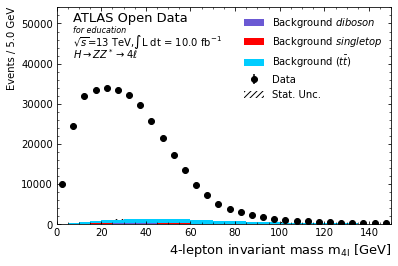

In [14]:
plot_data(data)